In [1]:
#### DO NOT RUN THIS CODE IN THE NOTEBOOK - copy paste into terminal in the HOME directory!

# git clone https://github.com/tensorflow/models.git

In [2]:
# !pip install s3fs -q
# !pip install tensorflow_hub -q
# !pip install tensorflow_datasets -q
# !pip install pycocotools -q
# !pip install gin-config -q
# !pip install immutabledict -q
# !pip install sentencepiece -q
# !pip install transformers -q
# !pip install evaluate -q
# !pip install sacrebleu -q
# !pip install bert_score -q
# !pip install sentence-transformers -q
# !pip install keras-nlp -q
# !pip install tensorflow-model-optimization -q
# !pip install pyarrow fastparquet -q
# !pip install -r official/projects/movinet/requirements.txt -q

In [3]:
import configparser

config = configparser.ConfigParser()
config.read('/home/ec2-user/.aws/credentials')

['/home/ec2-user/.aws/credentials']

In [4]:
# AWS credentials and S3 settings
aws_access_key_id = config["default"]['aws_access_key_id']
aws_secret_access_key = config["default"]['aws_secret_access_key']
bucket_name = 'asl-capstone'
s3_URI = 's3://asl-capstone/'

In [5]:
import s3fs
fs = s3fs.S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)

import boto3
s3 = boto3.client('s3',aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key,
                  region_name = 'us-west-2')


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Tuple
import matplotlib.pyplot as plt
import evaluate
# import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split

pd.set_option('max_colwidth', 400)

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)
tf.keras.backend.clear_session()

2023-12-06 23:55:41.064230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 23:55:41.767396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# !export XLA_PYTHON_CLIENT_PREALLOCATE=false
# !export XLA_FLAGS="--xla_gpu_strict_conv_algorithm_picker=false --xla_gpu_force_compilation_parallelism=1"

In [8]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, TFT5ForConditionalGeneration #, TFT5EncoderModel
# from transformers.modeling_tf_outputs import TFBaseModelOutputWithPastAndCrossAttentions

# with tf.device("/GPU:0"):
tokenizer = AutoTokenizer.from_pretrained("t5-base")
# model = TFAutoModelForSeq2SeqLM.from_pretrained("deanna-emery/ASL_t5_word_epoch15_1204")
model = TFAutoModelForSeq2SeqLM.from_pretrained("deanna-emery/ASL_t5_movinet_sentence")

model.trainable = True

# tokenizer = AutoTokenizer.from_pretrained("t5-large")
# model = TFT5ForConditionalGeneration.from_pretrained("t5-large")
# encoder_model = T5EncoderModel.from_pretrained("t5-large")

ENCODER_DIM = 768
# ENCODER_DIM = 1024


model.summary()

/opt/tensorflow/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
2023-12-06 23:55:45.963956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See 

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  109628544 
                                                                 
 decoder (TFT5MainLayer)     multiple                  137949312 
                                                                 
Total params: 222903552 (850.31 MB)
Trainable params: 222903552 (850.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.trainable = True

# for i in range(3):
#     model.encoder.block[-(i+3)].trainable = False

# for i in range(10):
#     model.encoder.block[-(i+1)].trainable = False

model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  109628544 
                                                                 
 decoder (TFT5MainLayer)     multiple                  137949312 
                                                                 
Total params: 222903552 (850.31 MB)
Trainable params: 222903552 (850.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
s3_files = fs.ls('s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/')
s3_files = ['s3://' + file for file in s3_files]
len(s3_files)

s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/


20404

In [11]:
video_files = pd.read_parquet("s3://asl-capstone/youtube-asl/1000-samples/masterfile_final.parquet")

# video_files = pd.read_parquet("s3://asl-capstone/youtube-asl/test_sample/numpy_files/RGB/masterfile.parquet")
video_files = video_files.drop_duplicates().reset_index(drop=True)
video_files['movinet_path'] = video_files.path.str.replace("/numpy_files/", '/movinet_embedding/')
video_files['caption_cleaned'] = video_files.caption.str.lower().str.replace(r'\[*\]', ' ').str.replace('\t',' ').str.replace('\n',' ').str.replace('…', ' ').str.replace('–', ' ').str.replace('/', ' ').str.replace('*', ' ').str.replace('-', ' ').str.replace('  ',' ').str.replace('...',' ').str.replace('..','.').str.replace('??','?').str.replace('!!','!').str.replace('♪', '').str.replace('♫','').str.replace('#','').str.strip(' ')

video_files = video_files[video_files['caption_cleaned']!='']
video_files = video_files[video_files['caption_cleaned']!=' ']
video_files = video_files[video_files['caption_cleaned']!='.']
video_files = video_files[video_files['caption_cleaned']!='[demonstrates sign]']
video_files = video_files[video_files['caption_cleaned']!='[music]']
video_files = video_files[video_files['caption_cleaned']!='(music)']
video_files = video_files[video_files['caption_cleaned']!='captioned by www.aslcaptions.com']
video_files = video_files[video_files['caption_cleaned']!='captioned by aslcaptions.com']
# video_files = video_files[video_files['caption_cleaned'].str.contains('&')==False]
# video_files = video_files[video_files['caption_cleaned'].str.contains('www.')==False]

video_files = video_files.dropna(subset=['caption_cleaned'])

video_files = video_files.groupby("caption_cleaned").head(5)

print(video_files.shape)
video_files.head()

(57672, 4)


,caption,path,movinet_path,caption_cleaned
0,Hello everyone!,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4fqpBXE0_Dc_0.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4fqpBXE0_Dc_0.npy,hello everyone!
1,"I am Kelly Matthews,",s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4fqpBXE0_Dc_1.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4fqpBXE0_Dc_1.npy,"i am kelly matthews,"
2,and I am the\nResearch Coordinator,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4fqpBXE0_Dc_2.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4fqpBXE0_Dc_2.npy,and i am the research coordinator
3,and Outreach Coordinator\nat NCDHR.,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4fqpBXE0_Dc_3.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4fqpBXE0_Dc_3.npy,and outreach coordinator at ncdhr.
4,My name is on that flyer,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4fqpBXE0_Dc_4.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4fqpBXE0_Dc_4.npy,my name is on that flyer


In [12]:
video_files = video_files[video_files['movinet_path'].isin(s3_files)]
n_files = len(video_files)
print(n_files)
video_files.head()

19996


,caption,path,movinet_path,caption_cleaned
270,Sign with me!,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4zPLsd-C7cI_2.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4zPLsd-C7cI_2.npy,sign with me!
271,Number,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4zPLsd-C7cI_3.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4zPLsd-C7cI_3.npy,number
272,Number 1,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4zPLsd-C7cI_4.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4zPLsd-C7cI_4.npy,number 1
273,Number 2,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4zPLsd-C7cI_5.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4zPLsd-C7cI_5.npy,number 2
274,Number 3,s3://asl-capstone/youtube-asl/1000-samples/numpy_files/4zPLsd-C7cI_6.npy,s3://asl-capstone/youtube-asl/1000-samples/movinet_embedding/4zPLsd-C7cI_6.npy,number 3


<Axes: >

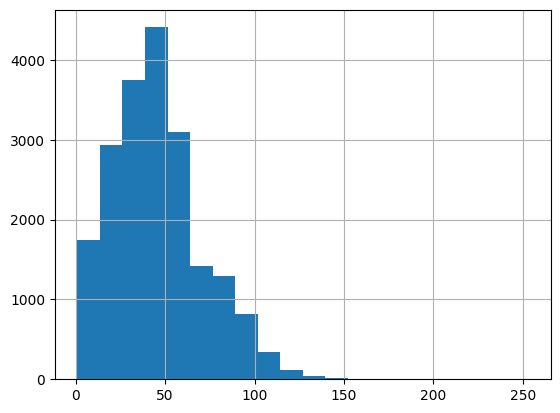

In [13]:
# video_files[(video_files['caption_cleaned'].str.len() > 40) & (video_files['caption_cleaned'].str.len() < 60)].caption_cleaned.unique()

video_files['caption_cleaned'].str.len().hist(bins=20)

In [14]:
### Start at training mini model to convert from to correct shape for T5
# # Loss function: CosineSimilarity.
# # Minimize for cosine sim between avg label emb and avg vid emb (after flattening)?
# vid_labels = tokenizer(video_files['caption_cleaned'].to_list(), return_tensors="tf", padding=True)
# label_embeds = model.encoder.embed_tokens(vid_labels.input_ids)
# label_embeds_avg = tf.math.reduce_mean(label_embeds, axis=1)

In [15]:
train_files, test_files = train_test_split(video_files, train_size=0.8, random_state=210)
test_files, val_files = train_test_split(test_files, train_size=0.9, random_state=210)

# train_files = train_files.sample(10)
# test_files = test_files.sample(10)
# val_files = val_files.sample(16)



print(train_files.shape)
print(test_files.shape)
print(val_files.shape)

(15996, 4)
(3600, 4)
(400, 4)


In [22]:
def data_generator(file_paths_df, n_frames=256, max_tokens=128):
    for _, row in file_paths_df.iterrows():
        # try:
        with fs.open(row['movinet_path'], 'rb') as f:
            vid_embedding = np.load(f)[0] #.astype(np.float16)

        if vid_embedding.shape[0] == 0:
            print(row['movinet_path'])
            fs.rm(row['movinet_path'])
            pass

        
        if vid_embedding.shape[0] < n_frames:
            # for shorter frame lengths, pad with zeros
            padding = tf.zeros((tf.constant(n_frames) - vid_embedding.shape[0], 
                                vid_embedding.shape[1]))
            
            attention_mask = tf.concat([tf.ones(vid_embedding.shape[0]), 
                                        tf.zeros(tf.constant(n_frames) - vid_embedding.shape[0])], 
                                       axis=0)
            
            vid_embedding = tf.concat([vid_embedding, padding], axis=0)
            
        else:
            # for exactly right size, just output attention_mask
            vid_embedding = vid_embedding[:n_frames]
            attention_mask = tf.ones(vid_embedding.shape[0])
            
        # elif vid_embedding.shape[0] > n_frames:
        #     # for longer frame lengths, interpolate
        #     vid_embedding = vid_embedding[:n_frames]
        #     attention_mask = tf.ones(vid_embedding.shape[0])
        
        
        label = tokenizer(row['caption_cleaned'], return_tensors="tf", 
                           padding='max_length', max_length=max_tokens, truncation=True).input_ids[0]
        # label = row['caption']
        
        yield {'inputs_embeds':vid_embedding, #'input_ids':None, 'training':True,
               'attention_mask':attention_mask, 'labels':label}
        # except:
        #     print(vid_embedding.shape, row['movinet_path'])


In [48]:
# Create TensorFlow Dataset for model input. 
N_FRAMES = 320
MAX_TOKENS = 128

train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(train_files, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(MAX_TOKENS), dtype=tf.int32)}
                       ))

test_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(test_files, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(MAX_TOKENS), dtype=tf.int32)}
                       ))

eval_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(val_files, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(MAX_TOKENS), dtype=tf.int32)}
                       ))

In [49]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from sentence_transformers import SentenceTransformer, util
import evaluate


# push_to_hub_callback = PushToHubCallback(
#     output_dir="./t5_movinet_word", tokenizer=tokenizer, hub_model_id="deanna-emery/ASL_t5_movinet"
# )


bleu = evaluate.load("sacrebleu")
# bertscore = evaluate.load("bertscore",device="cpu")
# st_sim = SentenceTransformer('all-mpnet-base-v2',device="cpu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]

    # Decode tokens to words
    preds = np.where(preds >= 0, preds, tokenizer.pad_token_id)
    labels = np.where(labels >= 0, labels, tokenizer.pad_token_id)

    try:
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
        # # Create SentenceTransformer embeddings from words
        # st_preds = st_sim.encode(decoded_preds)
        # st_labels = st_sim.encode(decoded_labels)
    
        # # Calculate cosine similarity
        # cos_sim = []
        # for p, l in zip(st_preds, st_labels):
        #     cos_sim.append(float(util.cos_sim(p, l)))
    
        # Calculate BLEU and BERT score
        result_1 = bleu.compute(predictions=decoded_preds, references=decoded_labels)
        # result_2 = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en", device="cpu")
    
        # Store results to dcit
        result = {"bleu": result_1["score"]}
        # result['avg_bertscore_f1'] = np.mean(result_2['f1'])
        # result['avg_sent_trans_sim'] = np.median(cos_sim)
    
        prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
        result["gen_len"] = np.mean(prediction_lens)
        result = {k: round(v, 4) for k, v in result.items()}
        return result
    except:
        pass

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, 
                                      eval_dataset=eval_dataset.batch(24, drop_remainder=True),
                                      batch_size=24,
                                      predict_with_generate=True,
                                      generate_kwargs={'max_new_tokens':128, 
                                                       'temperature':0.01,
                                                       'no_repeat_ngram_size':2,
                                                          'do_sample':True,
                                                          'top_k':50, 
                                                          'top_p':0.90,
                                                          # 'early_stopping':True,
                                                      }
                                     )


In [50]:
# # FIGURE OUT OPTIMIZER FOR t5

NUM_EPOCHS = 5
BATCH_SIZE = 24
VAL_BATCH_SIZE = 24

train_steps = len(train_files) // BATCH_SIZE
total_train_steps = train_steps * NUM_EPOCHS

test_steps = len(test_files) // VAL_BATCH_SIZE

# Set learning rate scheduler, optimizer, and loss function
initial_learning_rate = 5e-4
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps, warmup_target=5e-4, warmup_steps=600
)
# learning_rate = 1e-4

optimizer = tf.keras.optimizers.Adafactor(learning_rate=learning_rate)

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True)

metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top_1'), 
           tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5') ]

model.compile(optimizer=optimizer, metrics=metrics) 
#loss=model.hf_compute_loss

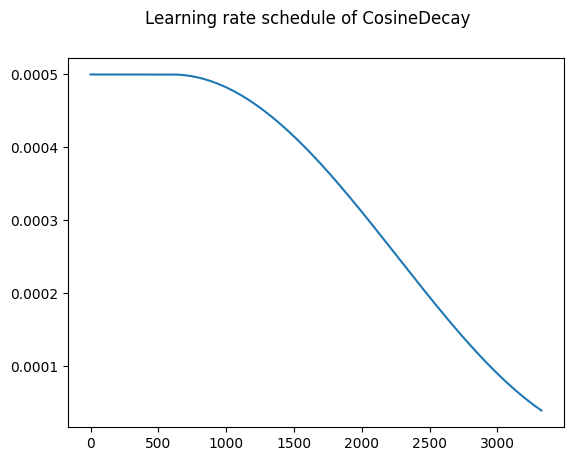

In [51]:
%matplotlib inline

def visualize_lr_schedule(opt, n_steps, step_s) -> Tuple[List[int], List[float]]:
    """Visualize tensorflow keras scheduler learning rate over the course of n_steps training steps.

    Args:
        opt (LearningRateSchedule): learning rate scheduler to be visualized.
        n_steps (int): number of training steps to visualize over.
        step_s (int): sampling step of the training steps, i.e. takes each step_s in the interval [0, n_steps].

    Returns:
        Tuple[List[int], List[float]]: returns x (steps), y (lr values) values of the plot.
    """
    lr = []
    steps = list(range(0, n_steps, step_s))

    for step in steps:
        lr_at_s = opt(step).numpy()
        lr.append(lr_at_s)

    plt.suptitle(f'Learning rate schedule of {type(opt).__name__}')
    plt.plot(steps, lr)

    return steps, lr


steps, lr_values = visualize_lr_schedule(learning_rate, n_steps=total_train_steps, step_s=5)

In [52]:
%%time

# with tf.device("/GPU:0"):
history = model.fit(train_dataset.batch(BATCH_SIZE,drop_remainder=True), 
                    validation_data=test_dataset.batch(VAL_BATCH_SIZE,drop_remainder=True),
                    batch_size = BATCH_SIZE,
                    validation_batch_size = VAL_BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    # predict_with_generate = True,
                    # steps_per_epoch=train_steps,
                    # validation_steps=test_steps,
                    callbacks=[metric_callback],
                    verbose=1)

Epoch 1/5
    666/Unknown - 1949s 3s/step - loss: 0.2351 - top_1: 0.9496 - top_5: 0.9736

2023-12-07 05:24:07.111344: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16830050142986932903
2023-12-07 05:24:07.111384: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16197297226241811907
2023-12-07 05:24:07.111394: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2122708291111646090
2023-12-07 05:24:07.111402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16003037537626211462
2023-12-07 05:24:07.111641: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 15883464981596239054
2023-12-07 05:30:17.550720: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send item cancelled. Key hash: 139084017581381676
2023-12-07 05:30:17.550767: I tensorflow/core/framework/local_rendezvous.cc:409] Local rendezvous send 

666/666 [==============================] - 2493s 4s/step - loss: 0.2351 - top_1: 0.9496 - top_5: 0.9736 - val_loss: 0.3181 - val_top_1: 0.9413 - val_top_5: 0.9640 - bleu: 1.1898 - gen_len: 13.0052
Epoch 2/5
666/666 [==============================] - 2519s 4s/step - loss: 0.2173 - top_1: 0.9522 - top_5: 0.9760 - val_loss: 0.3255 - val_top_1: 0.9409 - val_top_5: 0.9638 - bleu: 1.5250 - gen_len: 13.0182
Epoch 3/5
666/666 [==============================] - 2755s 4s/step - loss: 0.1965 - top_1: 0.9554 - top_5: 0.9789 - val_loss: 0.3372 - val_top_1: 0.9405 - val_top_5: 0.9630 - bleu: 1.4326 - gen_len: 13.8776
Epoch 4/5
666/666 [==============================] - 2576s 4s/step - loss: 0.1776 - top_1: 0.9586 - top_5: 0.9815 - val_loss: 0.3415 - val_top_1: 0.9408 - val_top_5: 0.9633 - bleu: 1.9840 - gen_len: 12.7656
Epoch 5/5
666/666 [==============================] - ETA: 0s - loss: 0.1642 - top_1: 0.9610 - top_5: 0.9834

2023-12-07 08:23:12.929632: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Attempting to slice scalar input.
2023-12-07 08:23:12.930187: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [24,1,1] != values[1].shape = [] [Op:Pack] name: 
Traceback (most recent call last):

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/t

InvalidArgumentError: Exception encountered when calling layer 'decoder' (type TFT5MainLayer).

{{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: tft5_for_conditional_generation/decoder/strided_slice/

Call arguments received by layer 'decoder' (type TFT5MainLayer):
  • input_ids=tf.Tensor(shape=(24, 1), dtype=int32)
  • attention_mask=None
  • encoder_hidden_states=tf.Tensor(shape=(24, 320, 768), dtype=float32)
  • encoder_attention_mask=tf.Tensor(shape=(24, 320), dtype=int32)
  • inputs_embeds=None
  • head_mask=None
  • encoder_head_mask=None
  • past_key_values=None
  • use_cache=True
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False

In [53]:
predictions = []
labels = []

for batch in test_dataset.batch(24):
    try:
        test_outputs = model.generate(inputs_embeds = batch['inputs_embeds'], 
                                      attention_mask=batch['attention_mask'],  
                                      max_new_tokens=128, 
                                      temperature=0.01,
                                      # num_beams=2, 
                                      no_repeat_ngram_size=2,
                                      do_sample=True,
                                      top_k=50, 
                                      top_p=0.90, # try 0.5 and 0.2
                                      # early_stopping=True,
                                     ) 
    
        pred = tokenizer.batch_decode(test_outputs, skip_special_tokens=True)
        label = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
    
        predictions += pred
        labels += label
    except:
        pass

2023-12-07 08:26:40.931058: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: InvalidArgumentError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} dims must represent a vector, got shape [11,11] [Op:Fill] name: 
Traceback (most recent call last):

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_26535/4162970636.py", line 19, in data_generator
    tf.zeros(tf.constant(n_frames) - vid_embedding.shape[0])],

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/util/traceback_uti

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} InvalidArgumentError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} dims must represent a vector, got shape [11,11] [Op:Fill] name: 
Traceback (most recent call last):

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_26535/4162970636.py", line 19, in data_generator
    tf.zeros(tf.constant(n_frames) - vid_embedding.shape[0])],

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/opt/tensorflow/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 6656, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} dims must represent a vector, got shape [11,11] [Op:Fill] name: 


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

In [54]:
for batch in eval_dataset.batch(24):
    try:
        test_outputs = model.generate(inputs_embeds = batch['inputs_embeds'], 
                                      attention_mask=batch['attention_mask'],  
                                      max_new_tokens=128, 
                                      temperature=0.01,
                                      # num_beams=2, 
                                      no_repeat_ngram_size=2,
                                      do_sample=True,
                                      top_k=50, 
                                      top_p=0.90, # try 0.5 and 0.2
                                      # early_stopping=True,
                                     ) 
    
        pred = tokenizer.batch_decode(test_outputs, skip_special_tokens=True)
        label = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
    
        predictions += pred
        labels += label
    except:
        pass

In [39]:
bleu_standard = evaluate.load('bleu')
st_sim = SentenceTransformer('all-mpnet-base-v2',device="cpu")
# bertscore = evaluate.load("bertscore",device="cpu")

In [55]:
bleu_standard_metric = bleu_standard.compute(predictions=predictions, references=labels)
bleu_metric = bleu.compute(predictions=predictions, references=labels)
# bertscore_metric = bertscore.compute(predictions=predictions, references=labels, lang="en", device="cpu")

# Create SentenceTransformer embeddings from words
st_preds = st_sim.encode(predictions)
st_labels = st_sim.encode(labels)

# Calculate cosine similarity
cos_sim = []
for p, l in zip(st_preds, st_labels):
    cos_sim.append(float(util.cos_sim(p, l)))

In [56]:
print('BLEU Standard')
print(bleu_standard_metric)
print('SacreBLEU')
print(bleu_metric)
# print('Mean BERTScore')
# print(np.mean(bertscore_metric['f1']))
print("Mean ST cosine sim")
print(np.mean(cos_sim))

######## 11351 datapoints
# BLEU Standard
# {'bleu': 0.0055599118181396245, 'precisions': [0.12159820609519927, 0.007017947537965945, 0.00164354743277891, 0.0009946442234123947], 'brevity_penalty': 0.9097479392501068, 'length_ratio': 0.9135859949715989, 'translation_length': 19622, 'reference_length': 21478}
# SacreBLEU
# {'score': 0.5559911818139627, 'counts': [2386, 122, 25, 13], 'totals': [19622, 17384, 15211, 13070], 'precisions': [12.159820609519926, 0.7017947537965946, 0.164354743277891, 0.09946442234123948], 'bp': 0.9097479392501068, 'sys_len': 19622, 'ref_len': 21478}
# Mean BERTScore
# 0.842458401358053
# Mean ST cosine sim
# 0.14556280111952166

######## 13378 datapoints
# BLEU Standard
# {'bleu': 0.009477871726519475, 'precisions': [0.12432853250291942, 0.009819682815555073, 0.003377882214715817, 0.0019567283501984683], 'brevity_penalty': 1.0, 'length_ratio': 1.0152946290953642, 'translation_length': 25690, 'reference_length': 25303}
# SacreBLEU
# {'score': 0.9477871726519478, 'counts': [3194, 226, 69, 35], 'totals': [25690, 23015, 20427, 17887], 'precisions': [12.432853250291942, 0.9819682815555073, 0.3377882214715817, 0.1956728350198468], 'bp': 1.0, 'sys_len': 25690, 'ref_len': 25303}
# Mean BERTScore
# 0.8448950230897097
# Mean ST cosine sim
# 0.1621186593375244

######## 19996 datapoints, 5 epochs
# BLEU Standard
# {'bleu': 0.012806860474137838, 'precisions': [0.13494694960212203, 0.013957509881422924, 0.0054226918798665185, 0.0026902990979585377], 'brevity_penalty': 0.9947090070850595, 'length_ratio': 0.9947229551451188, 'translation_length': 9048, 'reference_length': 9096}
# SacreBLEU
# {'score': 1.280686047413783, 'counts': [1221, 113, 39, 17], 'totals': [9048, 8096, 7192, 6319], 'precisions': [13.494694960212202, 1.3957509881422925, 0.5422691879866518, 0.2690299097958538], 'bp': 0.9947090070850593, 'sys_len': 9048, 'ref_len': 9096}
# Mean ST cosine sim
# 0.19157156346736579

######## 19996 datapoints, 10 epochs
# BLEU Standard
# {'bleu': 0.01527910090664875, 'precisions': [0.14048839312631897, 0.017055048969942588, 0.006277344493056876, 0.003907097894508357], 'brevity_penalty': 0.9813340795367348, 'length_ratio': 0.9815061399615328, 'translation_length': 6634, 'reference_length': 6759}
# SacreBLEU
# {'score': 1.5279100906648755, 'counts': [932, 101, 33, 18], 'totals': [6634, 5922, 5257, 4607], 'precisions': [14.048839312631896, 1.7055048969942588, 0.6277344493056877, 0.3907097894508357], 'bp': 0.9813340795367348, 'sys_len': 6634, 'ref_len': 6759}
# Mean ST cosine sim
# 0.20208033932114344

BLEU Standard
{'bleu': 0.01527910090664875, 'precisions': [0.14048839312631897, 0.017055048969942588, 0.006277344493056876, 0.003907097894508357], 'brevity_penalty': 0.9813340795367348, 'length_ratio': 0.9815061399615328, 'translation_length': 6634, 'reference_length': 6759}
SacreBLEU
{'score': 1.5279100906648755, 'counts': [932, 101, 33, 18], 'totals': [6634, 5922, 5257, 4607], 'precisions': [14.048839312631896, 1.7055048969942588, 0.6277344493056877, 0.3907097894508357], 'bp': 0.9813340795367348, 'sys_len': 6634, 'ref_len': 6759}
Mean ST cosine sim
0.20208033932114344


In [57]:
for i in range(20,40):
    print('prediction: ', predictions[i])
    print('label: ', labels[i])
    print(' ')

prediction:  2. camp responsibilities &amp; duties :
label:  1. fundraising coordinator
 
prediction:  i am currently living in california.
label:  you can see all the deep details hidden and explore
 
prediction:  my friends,
label:  i really look forward to!
 
prediction:  i'm going to show you how to do it.
label:  and you can turn student feedback off,
 
prediction:  hello! i'm rogan and welcome.
label:  i'm jethro wooddall.
 
prediction:  or a conjunction
label:  dentures washington his wood? no
 
prediction:  my dog (who is my mom)
label:  you want save planet (way can do it)
 
prediction:  and what happens when a child is placed in  foster care
label:  to be involved in big brothers big sisters.
 
prediction:  i’m a big advocate for deaf rights.
label:  join us
 
prediction:  at this point, he is unable to provide any educational opportunities for his students.
label:  but today, i want to focus mainly on illinois school for the deaf,
 
prediction:  go for it!
label:  that would

In [117]:
# from sklearn.metrics import accuracy_score

# accuracy_score(labels, predictions)

0.5048086359175662

In [58]:
n_files

19996

In [59]:
word_pred = pd.DataFrame({'caption':labels, 'prediction':predictions, 
                          'st_cos_sim':cos_sim})
word_pred.to_parquet(f"s3://asl-capstone/t5_movinet_sent_epoch10_{n_files}.parquet")
word_pred

,caption,prediction,st_cos_sim
0,we have a sad update to the story of the chicago woman was killed when her baby was cut from,the senate voted to confirm the resolution and set the record straight at 7 2,0.141476
1,we also updated the irid website,we've raised funds to fund events and initiatives that are specific to our membership.,0.247976
2,she discussed the team's fight for equal pay and said,"adams said he did not think if trump did,",0.202298
3,and bombings spanning three countries.,police say he was assaulted by a group of people who claimed christianity.,0.174588
4,"those techniques, including waterboarding, have been described by many as torture.",the senate and fda are proposing tougher sentences for those accused of,0.280446
...,...,...,...
707,"really, i am still uncertain of the efficiency of this program that was implemented",i am excited to share this video with you today.,0.088498
708,"over time, qabil's personality became more",qabil is adam's twin sister.,0.572011
709,his power to smear him.,"four months ago, a cat named yvonne swann came to the rescue.",-0.005715
710,remember,eat,0.225695


In [64]:
word_pred.sort_values('st_cos_sim', ascending=False).head(50)

,caption,prediction,st_cos_sim
404,praise the lord,praise the lord,1.000000
601,fox,fox,1.000000
624,delicious,delicious,1.000000
217,"rainbows rainbows high up in the sky,",rainbows rainbow high up in the sky.,0.970885
581,a d grade,a c grade,0.920364
418,scrub your hands for at least 20 seconds.,dry your hands using a clean towel.,0.894355
440,school performances for deaf children,encouraging deaf performers to participate.,0.863475
309,"raindrops, raindrops falling to the ground.",raindrops.,0.833784
608,"he called himself, ""i am""","jesus called himself, ""i am""",0.830660
698,a radical life of discipleship to those around him!,a radical life of obedience to god.,0.824819


In [60]:
!huggingface-cli whoami


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


deanna-emery


In [61]:
# !huggingface-cli whoami
# model = TFAutoModelForSeq2SeqLM.from_pretrained("deanna-emery/ASL_t5_word_epoch15_1204")


# model.save_pretrained("/home/ec2-user/ASL-Translator/modeling/t5_word_epoch12_1203")
model.push_to_hub("deanna-emery/ASL_t5_movinet_sentence", revision="sent_epoch10_1206")
# trainer.save_model("path/to/model")

# test = TFT5ForConditionalGeneration.from_pretrained("/home/ec2-user/ASL-Translator/modeling/t5_i3d_epoch5_1201")


tf_model.h5:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

In [33]:
# Try training on just WLASL and MSASL

inputs = next(iter(train_dataset.batch(10)))
test_outputs = model.generate(inputs_embeds = inputs['inputs_embeds'], attention_mask=inputs['attention_mask'],  
                              max_new_tokens=128, 
                              # num_beams=2, 
                              no_repeat_ngram_size=2,
                              do_sample=True,
                              top_k=80, 
                              top_p=0.90, # try 0.5 and 0.2
                              # early_stopping=True,
                             ) # TOP-K TOP-P

predictions = tokenizer.batch_decode(test_outputs, skip_special_tokens=True)
test_labels = tokenizer.batch_decode(inputs['labels'], skip_special_tokens=True)

for pred, lab in zip(predictions, test_labels):
    print('prediction: ', pred)
    print('true label: ', lab)
    print('')

prediction:  i will show you the step by step process that goes into picking out and cleaning your trophy case.
true label:  they're very sharp.

prediction:  you want to look for something that can be easily maneuvered through, and if you're not familiar with that type of climbing you can always call an experienced professional to come to your aid.
true label:  then go back in and massage it into your scalp cause you are going to want to moisturize your hair.

prediction:  and, that's going to be our last line in this little story.
true label:  let us talk about oily skin first.

prediction:  you want to always make sure that your kite has an approved service contract with your mechanic so that you can be sure you get the job done right the first time.
true label:  now, slowly begin to connect these movements, exhaling as you drop the chin toward the chest and inhaling as the ear rolls up towards the shoulder blades, and do this as long as you're comfortable.

prediction:  we all need

In [27]:
# # training
# inputs = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="tf").input_ids
# labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="tf").input_ids
# outputs = model(inputs, labels=labels)
# loss = outputs.loss
# logits = outputs.logits
# print(loss)
# print(logits)

# # inference
# inputs = tokenizer(
#    [ "studies have shown that owning a cat is good for you", "i have always wanted to have a pet"], return_tensors="pt", padding=True
# ).input_ids  # Batch size 1

# # Convert from tokens to embeddings
# encoder_outputs = encoder_model(input_ids=inputs)
# encoder_outputs['last_hidden_state'] = encoder_outputs['last_hidden_state'].detach().numpy()
# print(encoder_outputs['last_hidden_state'].shape)

# # Generate text from embeddings
# outputs = model.generate(encoder_outputs=encoder_outputs)
# # outputs = model.generate(inputs)


# print("Response: \n")
# print(tokenizer.batch_decode(outputs, skip_special_tokens=True))
# # studies have shown that owning a dog is good for you

In [31]:
# # training
# embeddings = tf.convert_to_tensor(vid_embedding)
# mask = tf.convert_to_tensor(attention_mask)

# labels = tokenizer(captions, return_tensors="tf", padding=True).input_ids
# outputs = model(input_ids=None, inputs_embeds=embeddings, 
#                      attention_mask=mask, labels=labels, training=True)
# print(outputs.loss)
# # loss = outputs.loss
# # logits = outputs.logits
# # print(loss)
# # print(logits)

In [21]:
# model.generate(encoder_outputs=encoder_outputs)
# tokenizer.decode(model.generate(inputs_embeds=encoder_outputs)[0], skip_special_tokens=True)

/opt/tensorflow/lib/python3.10/site-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
2023-11-08 04:39:47.301175: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55703850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 04:39:47.301212: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-08 04:39:47.408791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 04:39:47.854060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-08 04:39:48.206243: I ./tensorflow/compiler/jit/device_compiler.h:186]

's its its it so it. so when it so it so it so it'

In [ ]:
# def movinet_T5_model(video_base_model, language_base_model,
#                       max_sequence_length=120,
#                       hidden_size = 1024,
#                       dropout=0.1,
#                       learning_rate=0.00005):
#     """
#     Builds a translation model that accepts videos, creates video embeddings using a MoViNet model,
#     and then passes the video embeddings into an encoder-decoder to generate text translation
#     """

#     # Set all models to trainable
#     video_base_model.trainable = True
#     language_base_model.trainable = True

#     # Set input structure for video inputs
#     video_inputs = tf.keras.layers.Input(shape=(max_sequence_length, 256, 256, 3), dtype=tf.int64, name='input_layer')
#     # token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
#     attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

#     # Get output embeddings from video model
#     movinet_out = video_base_model(video_inputs)
#     vid_embedding = movinet_out[0]['block4_layer3']

#     # Layer to flatten w x h x c dimensions
#     vid_embedding_flatten = tf.keras.layers.Reshape((120, 8 * 8 * 168), name='flatten')(vid_embedding)

#     # Hidden layer to force embeddings into correct shape for language model
#     vid_embedding_flatten = tf.keras.layers.Dense(1024, activation='linear', name='hidden_layer')(vid_embedding_flatten)

#     # # Pass embeddings into T5 language model
#     # language_output = language_base_model.generate(encoder_outputs=encoder_outputs, attention_mask=attention_mask)

#     # classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

#     # classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

#     # classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#     #                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#     #                              metrics='accuracy')



#     ### END YOUR CODE

#     model = tf.keras.Model(inputs=inputs, outputs=vid_embedding_flatten)

#     return model